# Reconstructing the booking history of the *UHCW* dataset
The [University Hospitals - Coventry & Warwickshire](https://www.uhcw.nhs.uk) (UHCW) has set up an online [portal](https://www.swiftqueue.co.uk/uhcw.php) to facilitate the booking of blood tests appointments in 18 centers around Coventry (UK).  


Available appointments have been recorded in the dataset `appointments.csv`.  A preliminary investigation of the dataset is done in `UHCW_EDA.ipynb`.

In this notebook we reconstruct the booking history of all appointments in all centers.

## Imports

In [2]:
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

## Helper functions

In [3]:
def cartesianProduct(left, right):
    """Returns Cartesian product of dataframe.
    From https://stackoverflow.com/a/53699013/9472676 with some arrangement:
    """
    # Rename columns if "key" already exists.
    if "key" in list(left.columns):
        key_x = "key_x"
    else:
        key_x = ""
    if "key" in list(right.columns):
        key_y = "key_x"
    else:
        key_y = ""
    new_key = hash("".join(list(left.columns) + list(right.columns)))
    left.rename(index=str, columns={"key": str(new_key)}, inplace=True)
    right.rename(index=str, columns={"key": str(new_key)}, inplace=True)
    # Calculate Cartesian product
    df_cartesian = left.assign(key=1).merge(
        right.assign(key=1), on='key'
    ).drop('key', 1)
    # Rename columns back to "key" if they had been changed
    left.rename(index=str, columns={str(new_key): "key"}, inplace=True)
    right.rename(index=str, columns={str(new_key): "key"}, inplace=True)
    if (key_x != "") and (key_y != ""):
        df_cartesian.rename(index=str, columns={str(new_key)+"_x": "key_x"}, inplace=True)
        df_cartesian.rename(index=str, columns={str(new_key)+"_y": "key_y"}, inplace=True)
    else:
        df_cartesian.rename(index=str, columns={str(new_key): "key"}, inplace=True)
    return df_cartesian


In [39]:
def spot_action(df, col='key'):
    """
    Detects booking and cancellation of dataframe.
    
    Parameter
    ---------
    df: dataframe with 0's and 1's
    
    Returns
    -------
    df, modified in place, replacing a transition from 0 to 1 with "cancel",
    a transition from 1 to 0 with "book",
    and "none" otherwise.
    """
    df[col] = df[col] - df[col].shift(1)
    df[col].fillna(method='bfill', inplace=True)
    df[col] = df[col].astype(int)
    df[col] = df[col].apply(lambda delta: "cancel" if delta == 1 else ("book" if delta == -1 else "none"))
    return df

## Data
Read in the `csv` file.

In [5]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
filename = 'sample_appointments.csv'  # appointments.csv
foldername = 'Data/UHCW'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)

filesize = os.path.getsize(filepath)
if filesize > 1e6:
    print("Size of data file: {}MB.".format(filesize//1000000))
elif filesize > 1e3:
    print("Size of data file: {}KB.".format(filesize//1000))
else:
    print("Size of data file: {}B.".format(filesize))
print("Loading data...")
raw_data = pd.read_csv(filepath, sep=';')
print("Number of records: {0}.".format(raw_data.shape[0]))
print("Column names:\n{}".format("\n".join(raw_data.columns)))

Tuesday 05 February 2019, 23:16:39
Size of data file: 291MB.
Loading data...
Number of records: 5117059.
Column names:
appointment timestamp
center age group
center id
test type
grab timestamp
CPU times: user 2.78 s, sys: 213 ms, total: 3 s
Wall time: 3 s


Work with a copy `df` of the `raw_data` dataframe.

In [9]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))

df = raw_data.copy()
df = df[['appointment timestamp', 'center id', 'center age group', 'test type', 'grab timestamp']]
df.columns = ['appointment', 'id', 'age group', 'test type', 'grab']
df['appointment'] = pd.to_datetime(df['appointment'])
df['grab'] = pd.to_datetime(df['grab'])
df = df[['id', 'test type', 'age group', 'grab', 'appointment']]

Tuesday 05 February 2019, 23:18:13
CPU times: user 1.8 s, sys: 148 ms, total: 1.95 s
Wall time: 1.94 s


## Drop *age group* 
In `UHCW_EDA.ipynb` we have noted that each center serves exactly one age group, so we will ignore the column `age group`:

In [10]:
df.drop('age group', axis=1, inplace=True)

## Restricted dataset
Also in `UHCW_EDA.ipynb`, we have noted that test center `10254` delivers only one test type and has the smallest number of records across all centers.
Therefore, for the sake of simplicity, we will begin with a restricted set containing only the data for center `10254`.
In a second phase, we will consider center `10352` which delivers two test types and has the smallest number of records given its number of test types.

In [11]:
selected_centers = [10254] # [10254, 10352]

In [20]:
df0 = df.loc[df['id'].apply(lambda x: x in selected_centers), :]

## Sorting for convenience of reading

In [21]:
df0.sort_values(['id', 'test type', 'appointment', 'grab'], inplace=True)

## Selecting an appointment

We will sometimes inspect one particular appointment.  Indeed, closer inspection of the dataset (not shown in `UHCW_EDA.ipynb`) reveals that the following appointment has been cancelled - and booked again.

In [13]:
selected_appointment = datetime.datetime(2019, 1, 17, 11, 30)

In [23]:
df0[df0['appointment'] == selected_appointment].head()

,id,test type,grab,appointment
213759,10254,Blood Test,2019-01-15 14:10:00,2019-01-17 11:30:00
267453,10254,Blood Test,2019-01-15 14:20:00,2019-01-17 11:30:00
321128,10254,Blood Test,2019-01-15 14:30:00,2019-01-17 11:30:00
374779,10254,Blood Test,2019-01-15 14:40:00,2019-01-17 11:30:00
428669,10254,Blood Test,2019-01-15 14:50:00,2019-01-17 11:30:00


## Generating the "schedule"
It turns out that the `selected_appointment` was initially not available, and became available.  That is, it had been already booked at the beginning of the dataset and was subsequently cancelled.  To detect this, we generate the `schedule`, that is, the full list of (`grab`, `appointment`) pairs (where `grab` does not occur after `appointment`) from the original dataset `df`.  

We first generate the full list of `grab` timestamps:

In [16]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
grabs = pd.DataFrame()
grabs['grab'] = df['grab'].drop_duplicates().reset_index(drop=True).sort_values(ascending=True)

Tuesday 05 February 2019, 23:27:39
CPU times: user 2.66 ms, sys: 231 µs, total: 2.89 ms
Wall time: 2.59 ms


then the full list of `appointment` timestamps:

In [17]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
appointments = pd.DataFrame()
appointments['appointment'] = df['appointment'].drop_duplicates().reset_index(drop=True).sort_values(ascending=True)

Tuesday 05 February 2019, 23:28:35
CPU times: user 2.85 ms, sys: 660 µs, total: 3.51 ms
Wall time: 2.71 ms


Then we calculate their Cartesian product and keep only the relevant side of the diagonal:

In [18]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
schedule = cartesianProduct(grabs, appointments)
schedule.query('grab <= appointment', inplace=True)

Tuesday 05 February 2019, 23:29:24
CPU times: user 26.4 ms, sys: 10.2 ms, total: 36.6 ms
Wall time: 34.4 ms


By inspection we may now see the `grab` timestamps which are missing in `df` for the `selected_appointment`:

In [19]:
schedule[schedule['appointment'] == selected_appointment].head()

,grab,appointment
1,2019-01-15 13:40:00,2019-01-17 11:30:00
278,2019-01-15 13:50:00,2019-01-17 11:30:00
555,2019-01-15 14:00:00,2019-01-17 11:30:00
832,2019-01-15 14:10:00,2019-01-17 11:30:00
1109,2019-01-15 14:20:00,2019-01-17 11:30:00


Now we compare `df0` against `schedule` to spot the missing rows:

In [30]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
df0_compare = pd.merge(
    schedule,
    df0[['grab', 'appointment']].assign(key=1),
    on=['appointment', 'grab'],
    how='outer'
)
df0_compare.fillna(0, inplace=True)
df0_compare['key'] = df0_compare['key'].astype(int)

Tuesday 05 February 2019, 23:38:30
CPU times: user 8.51 ms, sys: 2 ms, total: 10.5 ms
Wall time: 9 ms


A `0` indicates that the (`grab`, `appointment`) pair is missing in `df0`, and a `1` that it was there:

In [31]:
df0_compare[df0_compare['appointment'] == selected_appointment].head()

,grab,appointment,key
1,2019-01-15 13:40:00,2019-01-17 11:30:00,0
278,2019-01-15 13:50:00,2019-01-17 11:30:00,0
555,2019-01-15 14:00:00,2019-01-17 11:30:00,0
832,2019-01-15 14:10:00,2019-01-17 11:30:00,1
1109,2019-01-15 14:20:00,2019-01-17 11:30:00,1


A transition from `0` to `1` represents a cancellation, and a transition from `1` to `0` represents a booking:

In [44]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))

df0_action = df0_compare.groupby(['appointment']).apply(spot_action)
df0_history = df0_action.loc[df0_action['key'] != "none", :]

Tuesday 05 February 2019, 23:48:26
CPU times: user 395 ms, sys: 12.9 ms, total: 408 ms
Wall time: 398 ms


Finally we extract the booking history for the `selected_appointment`:

In [43]:
df0_history[df0_history['appointment'] == selected_appointment]

,grab,appointment,key
832,2019-01-15 14:10:00,2019-01-17 11:30:00,cancel
22161,2019-01-16 10:50:00,2019-01-17 11:30:00,book


In [45]:
df0_bookings = df0_history.loc[df0_history['key'] == 'book', ['appointment', 'grab']]
df0_cancellations = df0_history.loc[df0_history['key'] == 'cancel', ['appointment', 'grab']]

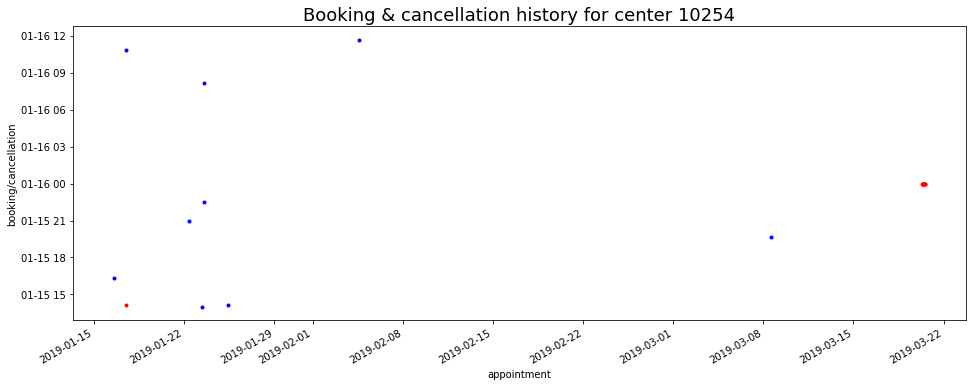

In [49]:
fig, ax = plt.subplots(figsize=(16, 6));
df0_bookings.plot(x='appointment', y='grab', style='.b', ax=ax);
df0_cancellations.plot(x='appointment', y='grab', style='.r', ax=ax);
ax.set_xlabel("appointment");
ax.set_ylabel("booking/cancellation");
ax.get_legend().remove()
ax.set_title("Booking & cancellation history for center {}".format(selected_centers[0]), fontsize=18);

<font size=6>*To be contined.*</font>

# Reconstruct *entire* booking history (of *all* appointments in *all* centers)?

Duplicate `schedule`, one for each `id`: 

In [ ]:
%%time 
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
schedule_duplicate = pd.concat(
    [schedule.assign(id=id_item).assign(type=type_item)
     for id_item in list(df['id'].unique())
     for type_item in list(df['test type'].unique())
     ]
    )

In [ ]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
schedule_duplicate.rename(index=str, columns={'type': 'test type'}, inplace=True)

In [ ]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
schedule_duplicate = schedule_duplicate[['id', 'test type', 'grab', 'appointment']]

In [ ]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
schedule_duplicate.sort_values(['id', 'test type', 'grab', 'appointment'],
    inplace=True
)

In [ ]:
schedule_duplicate[schedule_duplicate['appointment'] == selected_appointment].head()

In [ ]:
df0_cart = schedule_duplicate[schedule_duplicate['appointment'] == selected_appointment]

In [ ]:
df0 = df[df['appointment'] == selected_appointment]

In [ ]:
df0.assign(key=1).head()

In [ ]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
df_compare = pd.merge(
    schedule_duplicate,
    df.assign(key=1),
    on=['id', 'test type', 'appointment', 'grab'],
    how='outer'
)

In [ ]:
df_compare[df_compare['appointment'] == selected_appointment].head()

In [ ]:
#%%time
#print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
#df_compare = pd.merge(
#    df.assign(key=1),
#    schedule_duplicate,
#    how='outer',
#    #how='right',
#    #left_on=['grab', 'appointment', 'id', 'test type'],
#    #right_on=['grab', 'appointment', 'id', 'test type']
##    on=['id', 'test type', 'appointment', 'grab']
#    #on=['appointment', 'grab']
#)

In [ ]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))

df_compare.fillna(0, inplace=True)

In [ ]:
df_compare[df_compare['appointment'] == selected_appointment].head()

In [ ]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
df_compare['key'] = df_compare['key'].astype(int)

In [ ]:
df_compare[df_compare['appointment'] == selected_appointment].head()

In [ ]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))

df_action = df_compare.groupby(['id', 'test type', 'appointment']).apply(spot_action)

In [ ]:
df_action[df_action['appointment'] == selected_appointment].head()

In [ ]:
df_history = df_action.loc[df_action['key'] != "none", :]

In [ ]:
df_history.info()

In [ ]:
df_history[df_history['appointment'] == selected_appointment]